In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Expected Value of Cost function in population setting
## Projecting $p$ entries as sigmoids 
We have 

$$C(A, P) = \text{Tr}\left((B^* - B)\Sigma_X(B^* - B)\right),$$

where $$B = P^{-1}AP.$$

Here, $A$ is lower triangular and $P$ is a doubly stochastic matrix, namely

\begin{align*}
0 \leq &p_{ij} &\forall\ i,j = 1, \cdots, n\\
\sum_{j = 1}^n &p_{ij} = 1&\forall\ i = 1, \cdots, n\\
\sum_{i=1}^n &p_{ij} = 1 &\forall\ j = 1, \cdots, n\\
\end{align*}

In [42]:
# actual solution
n = 3
As = np.tril(np.random.rand(n, n) / 2)
As[np.abs(As) < 0.1] = 0
# As = np.zeros((n, n))
# As[0][2] = 0.5
# As[2][0] = 0.5
As = np.array([[0.8, 0.7, 0.6], [0.0, 0.7, 0.6], [0.0, 0.0, 0.5]])
Ps = np.identity(n)
Bs = np.linalg.inv(Ps) @ As @ Ps
Sigma = np.identity(n)
cov_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

rho = 0.0

print(f"A*:\n{np.round(As, 2)}\n\nP*:\n{Ps}")

A*:
[[0.8 0.7 0.6]
 [0.  0.7 0.6]
 [0.  0.  0.5]]

P*:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [43]:
def expected_cost(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)    
    B = np.matmul(P_inv, np.matmul(A, P))
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(cov_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix) # - 0.5 * rho * np.linalg.norm(P, 'f') ** 2

A = np.random.rand(n, n)
P = np.identity(n)
print(f"Expected cost: {expected_cost(A, P)}.")

Expected cost: 17.851313268225965.


In [44]:
print(np.linalg.norm(Ps, 'f'))

1.7320508075688772


## Dealing with the constraints
### Non-negativity constraints
To deal with the $n^2$ equality constraints, we use non-negative $\textit{lagrange multipliers}$ $\lambda_{ineq, i, j} \geq 0$, $i, j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n\sum_{j=1}^n \lambda_{ineq,i,j} \left(-p_{ij}\right).$$


## Dealing with equality constraints
To deal with the $n^2$ equality constraints, we use non-negative $\textit{lagrange multipliers}$ $\lambda_{ineq, i, j} \geq 0$, $i, j = 1, \cdots, n$. 

To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n\sum_{j=1}^n \lambda_{ineq,i,j} \left(-p_{ij}\right) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n p_{ij} - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n p_{ij} - 1\right).$$

In [45]:
def expected_cost_lagrange(A, P, As = As, Ps = Ps):
    exp_cost = expected_cost(A, P)
    lambda_cost = 0
    
    for i in range(n):
        lambda_cost += lambdas[0][i] * (sum(P[:, i]) - 1)
        lambda_cost += lambdas[1][i] * (sum(P[i]) - 1)
        
    return exp_cost - lambda_cost - np.sum(lambdasineq * P)

lambdas = np.zeros((2, n))
lambdasineq = np.zeros((n, n))
P = np.ones((n, n)) / n + np.random.rand(n, n) / n
print(f"Expected lagrange cost: {expected_cost(np.random.rand(n,n), Ps)}.")

Expected lagrange cost: 37.36438263979201.


## Optimizing $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$
let $$q(\mathbf{\lambda}) = \inf_{A, P} \mathcal{L}(A, P, \mathbf{\lambda}).$$
Then the $\textit{dual problem}$ is $$\max_{\mathbf{\lambda}} q(\mathbf{\lambda}).$$

## Deriving $q(\mathbf{\lambda})$
To minimize $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$, we will use gradient descent.

The partial derivative with respect to entries in $A$ is simple, 

$$\frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial a_{ij}} = \frac{\partial C(A, P)}{\partial a_{ij}}$$

Now, the partial derivative with respect to the entries in $p$ is more involved as it occurs also in exactly two equality constraints, namely in $\lambda_{row, i}$ and in $\lambda{col, j}$.

$$\frac{\partial\mathcal{L}(A, P_\sigma, \mathbf{\lambda})}{\partial p_{ij}} = \frac{\partial C(A, P)}{\partial p_{ij}} - \lambda_{ineq, i, j} - \lambda_{row, i} - \lambda_{col, j}.$$

Now, as $C(A, P)$ is unfortunately yet inevitably non-convex, we cannot expect to find the infimum $q(\mathbf{\lambda})$. However, let us consider a local minimum $\tilde{q}(\mathbf{\lambda})$, which we will find by gradient descent. 

For a sufficiently small step size, we will do this gradient descent until we have found a stationary point:
$$(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$$
Note that this is an $\textit{unconstrained}$ optimization problem now, which should make things more easy. 

Suppose that after a number of iterations, we have found this local minimum with parameters $\tilde{A}$, $\tilde{P}$. Then, we have that $$\tilde{q}(\mathbf{\lambda}) = \mathcal{L}(\tilde{A}, \tilde{P}, \mathbf{\lambda}).$$

In [57]:
# get gradient of our outcome
def grad_a(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
#     Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
#     Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    J = np.zeros((n, n))
    J[i][j] = 1
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return -2 * np.trace(np.matmul(cov_X, np.matmul((Bs - B).transpose(), np.matmul(P_inv, np.matmul(J, P)))))

def grad_p(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
#     Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
#     Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(A, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    return -2 * np.trace(np.matmul(cov_X, np.matmul((Bs - B).transpose(), B_grad))) - lambdasineq[i][j] - lambdas[0][j] - lambdas[1][i] #- rho * np.trace(np.matmul(P.transpose(), J))

def get_gradient(A, P):
    gradient = np.zeros(int(n * (n + 1) / 2 + n ** 2))
    index = 0
    
    for i in range(n):
        for j in range(i, n):
            # print(A[i][j])
            gradient[index] = grad_a(A, P, i, j, As = As, Ps = Ps)
            index += 1
            
    for i in range(n):
        for j in range(n):
            gradient[index] = grad_p(A, P, i, j, As = As, Ps = Ps)
            index += 1
            
    return gradient

get_gradient(A, P)

array([ -8.87843697,  -0.46983811,  -7.62214217,  -7.30467201,
         8.8006322 , -25.15988549, -39.11968211,   4.53476833,
        15.46758279, -24.55822577,   3.25933035,   8.51224385,
       -60.92651101,  -0.16723608,   4.78804022])

## Deriving the dual problem
Now that we have $\tilde{q}(\mathbf{\lambda})$, the solution to the dual problem is
$$\max_{\lambda} \tilde{q}(\mathbf{\lambda}),$$
which is again an unconstrained optimization problem, which we can also optimize by maximizing $\lambda$'s.

## Final Algorithm
To solve this problem, we simply iterate the following:
- While $\nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda}) \geq 0$:
    - $(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$
    - $\lambda_{ineq, i, j} = max(0, p_{ij})\ \forall i, j = 1, \cdots, n$
    - $\lambda_{row, i} = 1 - \sum_{j=1}^n p_{ij} \ \forall i = 1, \cdots, n$
    - $\lambda_{col, j} = 1 - \sum_{i=1}^n p_{ij} \ \forall j = 1, \cdots, n$
    
We will end up in a local optimum of $C(A, P)$ while also fullfilling the constraints.

[[0.09690892 0.02573775 0.04251947]
 [0.         0.01710717 0.30780215]
 [0.         0.         0.0414339 ]]
[[0.13495933 0.33097119 0.20917763]
 [0.16839756 0.22773779 0.1453917 ]
 [0.24475127 0.28544433 0.28305819]]


In [167]:
# Initial values
A = np.triu(np.random.rand(n, n)) / n
P = np.random.rand(n, n) / n
lambdas = np.zeros((2, n))
lambdasineq = np.zeros((n, n))

print(A)
print(P)

# optimize dual
def grad_lambda(A, P, i, row_or_col):
    if row_or_col:
        return - np.sum(P[i]) + 1
    else:
        return - np.sum(P[:, i]) + 1

lagrange = np.zeros((2, n))

for row_or_col in range(2):
    for i in range(n):
        lagrange[row_or_col][i] = grad_lambda(A, P, i, row_or_col)

print(np.sum(np.abs(lagrange)))

[[0.27983687 0.02942016 0.2225869 ]
 [0.         0.20646104 0.05044149]
 [0.         0.         0.20641659]]
[[0.10322872 0.00353254 0.25099017]
 [0.06539082 0.04294514 0.11580101]
 [0.14793131 0.14863082 0.10431663]]
4.03446565504766


In [168]:
# step size
eta = 1e-6

In [169]:
# rho = 0.05

In [176]:
# the algorithm
grad = get_gradient(A, P)
previous_cost = 1e12

# while gradient is larger than zero (or a value close)
while np.linalg.norm(grad, 2) > 0.001:
    # get gradient
    A_grad = np.zeros((n , n))
    A_grad[np.triu_indices(n)] = grad[:int(n * (n + 1) / 2)]
    P_grad = grad[int(n * (n + 1) / 2):].reshape((n , n))

    # update A and B according to gradient
    A -= eta * A_grad 
    P -= eta * P_grad 

    new_cost = expected_cost_lagrange(A, P)
    
    if new_cost > previous_cost:
        print("Revert gradient", eta, "\t", round(new_cost, 5), "\t", np.linalg.norm(grad, 2))
        
        A += 9 * eta * A_grad / 10
        P += 9 * eta * P_grad / 10
        
        # do not use the new_cost, revert to old A and P        
        eta /= 10
        
    else: # recompute gradient
        eta *= 1.1
        eta = min(eta, 0.1)

    previous_cost = new_cost

    grad = get_gradient(A, P)

    # print("Gradient:", np.linalg.norm(grad, 2), new_cost)    

    # update equality constraints
    for row_or_col in range(2):
        for i in range(n):
            lagrange[row_or_col][i] = 10 * grad_lambda(A, P, i, row_or_col)

    # update equality constraints
    lambdas = lagrange 

    lambdasineq = np.maximum(np.zeros((n, n)), -P) 

Revert gradient 3.7253567021098817e-07 	 3.43706 	 2.6957286173825064
Revert gradient 4.0363144401591725e-07 	 3.43705 	 1.4122152905433283
Revert gradient 4.373228005417699e-07 	 3.43706 	 3.598386433611846
Revert gradient 3.9159206167017934e-07 	 3.43705 	 2.191512176787743
Revert gradient 4.667063321757771e-07 	 3.43704 	 1.5841588325748501
Revert gradient 4.179029645489164e-07 	 3.43704 	 3.116893399965296
Revert gradient 3.7420295320312175e-07 	 3.43703 	 1.4636892095713911
Revert gradient 4.4598168572136867e-07 	 3.43705 	 4.55197321483681
Revert gradient 3.630413539389698e-07 	 3.43702 	 2.445935768804372
Revert gradient 4.326790946740158e-07 	 3.43703 	 3.7465087161982638
Revert gradient 3.874339469954107e-07 	 3.43701 	 2.9563361615992094
Revert gradient 4.617506176999762e-07 	 3.43702 	 3.3625092131636207
Revert gradient 3.7587769811849685e-07 	 3.43699 	 1.387604307088839
Revert gradient 4.47977676277079e-07 	 3.43703 	 5.058264479372678
Revert gradient 3.646661451288197e-07

Revert gradient 3.1685986030628035e-07 	 3.43647 	 1.3030579322505411
Revert gradient 3.4330834116816715e-07 	 3.43647 	 1.6038143040096693
Revert gradient 3.719644924469551e-07 	 3.43647 	 1.5868239736041523
Revert gradient 3.3306825595408846e-07 	 3.43647 	 2.8459407601359743
Revert gradient 2.9823938944956767e-07 	 3.43646 	 1.4046507950745621
Revert gradient 3.5544696939639325e-07 	 3.43648 	 4.522453959676185
Revert gradient 2.893436057008635e-07 	 3.43645 	 2.4618020231025843
Revert gradient 3.448448172805431e-07 	 3.43646 	 3.804385391571434
Revert gradient 3.0878447862282516e-07 	 3.43645 	 3.0449530945040095
Revert gradient 3.680147928336892e-07 	 3.43645 	 3.6623760569399564
Revert gradient 2.9957415951690607e-07 	 3.43643 	 1.4291731908245553
Revert gradient 3.2457979266034064e-07 	 3.43643 	 1.3245772026313358
Revert gradient 3.197024189673423e-07 	 3.43643 	 1.8317191057506974
Revert gradient 3.1489833626373725e-07 	 3.43642 	 2.2377214406886847
Revert gradient 3.101664432

Revert gradient 2.8202866960481375e-07 	 3.43602 	 2.7008961495286736
Revert gradient 2.7779070025210893e-07 	 3.43603 	 4.129028908042429
Revert gradient 2.48742194300789e-07 	 3.43601 	 1.352452170772561
Revert gradient 2.964553384058453e-07 	 3.43603 	 4.5117036091300635
Revert gradient 2.4132279616641833e-07 	 3.43601 	 3.2277066229763514
Revert gradient 2.6146615338993987e-07 	 3.436 	 1.8569660541129416
Revert gradient 2.575371714662621e-07 	 3.436 	 1.655283619304435
Revert gradient 2.790339522328946e-07 	 3.436 	 3.3400280986086064
Revert gradient 2.498554397243716e-07 	 3.43599 	 1.3379013581089094
Revert gradient 2.977821239546527e-07 	 3.436 	 3.507937241767574
Revert gradient 2.424028360816149e-07 	 3.43599 	 2.142914640605505
Revert gradient 2.626363448787675e-07 	 3.43598 	 1.7353748837653926
Revert gradient 2.5868977880070785e-07 	 3.43598 	 2.2308036967492453
Revert gradient 2.548025167150781e-07 	 3.43598 	 1.9882896440480895
Revert gradient 2.7607103422431767e-07 	 3.

Revert gradient 2.3522188086123634e-07 	 3.43566 	 3.0265672929805074
Revert gradient 2.3168726459838492e-07 	 3.43566 	 4.479783134274319
Revert gradient 2.0745978369847278e-07 	 3.43564 	 1.4071003409169225
Revert gradient 2.2477657514519137e-07 	 3.43564 	 1.3152329171156827
Revert gradient 2.2139891769637204e-07 	 3.43564 	 1.7809037579458058
Revert gradient 2.1807201540224e-07 	 3.43564 	 2.246503491304493
Revert gradient 2.1479510557866678e-07 	 3.43564 	 1.92764223258264
Revert gradient 2.3272418070239175e-07 	 3.43564 	 4.266349066632998
Revert gradient 2.0838826973771895e-07 	 3.43563 	 1.3535223208613847
Revert gradient 2.483608187125657e-07 	 3.43563 	 3.172273085140009
Revert gradient 2.0217253483169363e-07 	 3.43562 	 2.0347744004534687
Revert gradient 2.1904799647308474e-07 	 3.43562 	 1.5797852717439447
Revert gradient 2.157564208431137e-07 	 3.43562 	 1.8708612115946444
Revert gradient 2.125143068393719e-07 	 3.43561 	 1.6284150130902462
Revert gradient 2.30253002336760

Revert gradient 1.961833643133739e-07 	 3.43535 	 4.588394396896215
Revert gradient 1.7566851762975553e-07 	 3.43534 	 1.4808185459947867
Revert gradient 1.9033167320293405e-07 	 3.43534 	 1.2898088386202111
Revert gradient 1.8747161007880796e-07 	 3.43533 	 1.7323670660626367
Revert gradient 1.8465452435795022e-07 	 3.43533 	 2.1172413131285825
Revert gradient 1.818797702304219e-07 	 3.43533 	 1.7411328159331212
Revert gradient 1.9706138274976675e-07 	 3.43533 	 3.245261889751372
Revert gradient 1.9410019408102107e-07 	 3.43533 	 2.614031755826254
Revert gradient 1.911835024020436e-07 	 3.43533 	 4.107966637449517
Revert gradient 1.711914900622505e-07 	 3.43532 	 1.7103046953676855
Revert gradient 1.8548094548349808e-07 	 3.43532 	 1.3752059921934816
Revert gradient 1.826937729468505e-07 	 3.43531 	 1.525561833064692
Revert gradient 1.799484825061174e-07 	 3.43531 	 1.3152891952553367
Revert gradient 1.9496888929127525e-07 	 3.43531 	 1.7858207732047802
Revert gradient 1.9203914396181

Revert gradient 1.4431213104228441e-07 	 3.43508 	 2.733008547438685
Revert gradient 1.7199374542975725e-07 	 3.43508 	 4.740462706666044
Revert gradient 1.5400840130854714e-07 	 3.43508 	 4.062587888249912
Revert gradient 1.6686357409894607e-07 	 3.43507 	 1.4516298842175197
Revert gradient 1.643561598204437e-07 	 3.43507 	 1.9311765342865066
Revert gradient 1.6188642378536858e-07 	 3.43507 	 3.78988890936559
Revert gradient 1.4495799982985334e-07 	 3.43506 	 1.4984823804753789
Revert gradient 1.7276350325280264e-07 	 3.43507 	 3.753688649396589
Revert gradient 1.4063424158480392e-07 	 3.43506 	 1.4979793368231358
Revert gradient 1.6761037184570737e-07 	 3.43505 	 1.3232714848977805
Revert gradient 1.9976100012112472e-07 	 3.43506 	 2.8406349377763185
Revert gradient 1.1106546431339667e-07 	 3.43505 	 2.7187142077876074
Revert gradient 1.9380259649851102e-07 	 3.43506 	 3.863998205063943
Revert gradient 1.1852790528390036e-07 	 3.43505 	 2.748559926917398
Revert gradient 1.70929016478

Revert gradient 1.246171342608096e-07 	 3.43484 	 2.2350378102175896
Revert gradient 1.485209005745986e-07 	 3.43484 	 3.64079918852268
Revert gradient 1.3299010613e-07 	 3.43484 	 3.1778249887911882
Revert gradient 1.5849995626284213e-07 	 3.43484 	 4.317181870953153
Revert gradient 1.2902332217489225e-07 	 3.43483 	 1.5663709959907353
Revert gradient 1.3979297556040203e-07 	 3.43483 	 1.3896965740978113
Revert gradient 1.3769234392256686e-07 	 3.43483 	 1.9182653018136975
Revert gradient 1.3562327791426486e-07 	 3.43483 	 2.2141562345276204
Revert gradient 1.3358530320722743e-07 	 3.43483 	 1.6699578779601933
Revert gradient 1.447357478608688e-07 	 3.43483 	 2.3436983569104117
Revert gradient 1.5681692675689188e-07 	 3.43482 	 2.333143033475783
Revert gradient 1.27653289884057e-07 	 3.43482 	 1.3130555145784242
Revert gradient 1.5213944444598612e-07 	 3.43483 	 4.4871381670981565
Revert gradient 1.238456906808966e-07 	 3.43482 	 3.013718264747857
Revert gradient 1.3418316408833507e-0

Revert gradient 1.1261061969116915e-07 	 3.43464 	 1.3784726690230513
Revert gradient 1.3421132455022164e-07 	 3.43465 	 4.352982621864193
Revert gradient 1.0925170817237526e-07 	 3.43464 	 2.759732402276156
Revert gradient 1.1837101318605688e-07 	 3.43464 	 1.3160934898874432
Revert gradient 1.282515120091876e-07 	 3.43464 	 2.517368867096165
Revert gradient 1.1484028259623906e-07 	 3.43463 	 1.3075657666912466
Revert gradient 1.3686867616244612e-07 	 3.43464 	 2.7956402381656833
Revert gradient 1.1141486544560149e-07 	 3.43463 	 1.798172932398681
Revert gradient 1.2071473048252765e-07 	 3.43463 	 1.3994449461595786
Revert gradient 1.1890078252850642e-07 	 3.43463 	 1.6448374388815121
Revert gradient 1.1711409228501268e-07 	 3.43463 	 1.4290100164999042
Revert gradient 1.268896751734964e-07 	 3.43463 	 2.479674574035102
Revert gradient 1.249829379779004e-07 	 3.43462 	 2.5730816267312067
Revert gradient 1.2310485281193636e-07 	 3.43463 	 4.0284582359202705
Revert gradient 1.1023180829

Revert gradient 1.1364469784240436e-07 	 3.43447 	 2.676453866133812
Revert gradient 1.1193698937706153e-07 	 3.43447 	 4.389660469737299
Revert gradient 1.0023176562716127e-07 	 3.43447 	 1.3701831148837054
Revert gradient 1.194579877432609e-07 	 3.43447 	 4.54096651227609


KeyboardInterrupt: 

In [34]:
print(expected_cost_lagrange(A, P))

3.0000820843180063


In [159]:
# A_b, P_b = A.copy(), P.copy()

start
0 0	0 1	0 2	1 0	1 1	1 2	2 0	2 1	2 2	

No handles with labels found to put in legend.


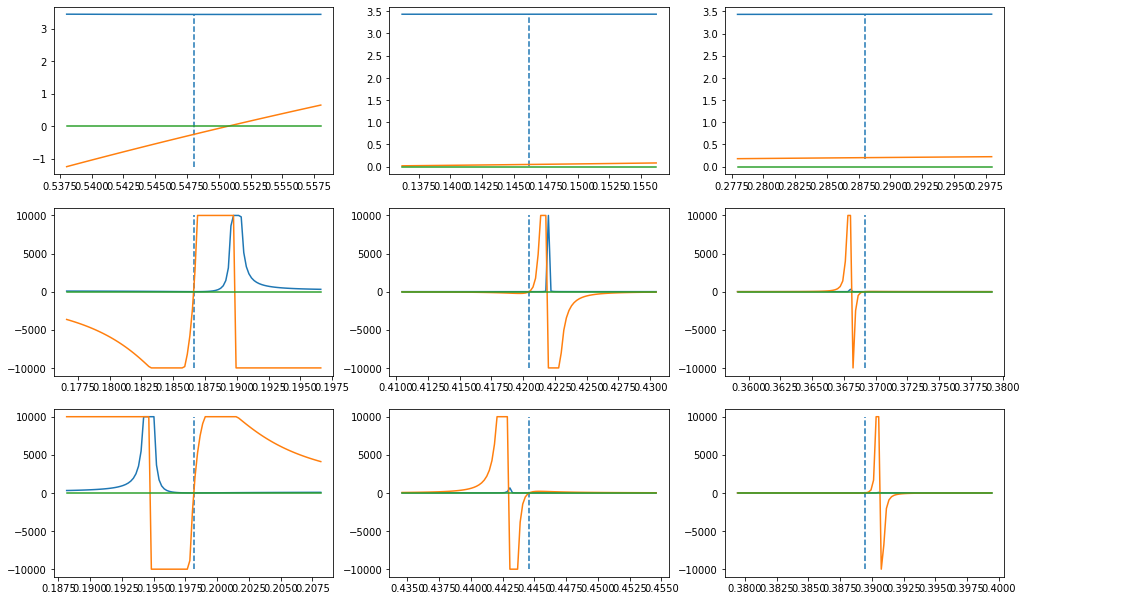

In [178]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients


# create figure
fig = plt.figure(1)

print("start")

for i in range(n):
    for j in range(n):
        print(i, j, end = "\t")
        P2 = P.copy()
        
        ax = fig.add_subplot(n, n, i*n +j + 1)
        p_list = np.linspace(P[i][j] - 0.01, P[i][j] + 0.01, 100)

        results = [[], []]

        for p in p_list:
            P2[i][j] = p
            results[0].append(min((expected_cost_lagrange(A, P2, As = As, Ps = Ps), 1e4)))
            results[1].append(max(min(grad_p(A, P2, i, j), 1e4), -1e4))
            
#         plt.yscale('log')
#         plt.locator_params(axis='x', nbins=6)
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([p_list[0], p_list[-1]],[0, 0])
        plt.vlines(P[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [63]:
print(A)

[[0.49093768 0.43631168 0.61191176]
 [0.         0.71591168 0.85313935]
 [0.         0.         0.79187517]]


In [32]:
print(np.linalg.inv(P.T))

[[ 0.01444364  1.05697398 -0.07047022]
 [-0.20016151 -0.06997581  1.27035922]
 [ 1.18639916  0.01237421 -0.19947309]]


In [33]:
print(np.round(np.linalg.inv(P) @ A @ P, 2))

# print(np.round(P.T @ U.T @ np.linalg.inv(P.T), 2))


[[ 0.13 -0.    0.01]
 [ 0.26  0.    0.13]
 [ 0.43  0.01  0.17]]


In [71]:
print(np.linalg.inv(P).T @ P.T)

[[ 1.00000000e+00 -4.67687769e-15  4.21198881e-15]
 [ 2.84613124e-14  1.00000000e+00  3.05056446e-14]
 [-2.22396738e-15  6.01340960e-15  1.00000000e+00]]


In [201]:
print(P)
print()
print(A)
print()
print(Ps)
print()
print(As)
print()

[[0.54802955 0.14619007 0.28797089]
 [0.18661379 0.42046855 0.36912562]
 [0.198155   0.44459112 0.38942461]]

[[0.62912316 0.17815734 0.46023867]
 [0.         0.50922377 0.36643886]
 [0.         0.         0.89795205]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

[[0.8 0.7 0.6]
 [0.  0.7 0.6]
 [0.  0.  0.5]]



In [200]:
print(np.round(np.linalg.inv(P) @ A @ P, 2))
print(np.round(np.linalg.inv(Ps) @ As @ Ps, 2))

[[ 0.84  0.54  0.5 ]
 [-0.    0.77  0.19]
 [ 0.03 -0.13  0.43]]
[[0.8 0.7 0.6]
 [0.  0.7 0.6]
 [0.  0.  0.5]]


In [50]:
print(np.linalg.det(P))

-0.008232145127464343


## Verification
First of all, let us look at $A$ and $P$. These should adhere to the constraints. We indeed see this is the case. Furthermore, let us look at our lambdas, they should all be (closely) equal to zero. Furthermore, let us look at the gradients, all gradients, as well as with respect to lambda, should be close to zero. Lastly, the expected cost of the lagrangian and the regular expected cost should be close to the global optimum, which is the trace of $\Sigma$.

In [38]:
print(Bs)

print(np.linalg.inv(P) @ A @ P)

[[0.13272058 0.         0.        ]
 [0.25819739 0.         0.12732276]
 [0.42976994 0.         0.16595142]]
[[ 1.31494522e-01 -1.49169200e-03  5.51649062e-03]
 [ 2.58262787e-01  3.72218878e-04  1.27227987e-01]
 [ 4.29497016e-01  5.48960254e-03  1.65786880e-01]]


In [51]:
# A = np.array([[ 0.00495261,  0.,          0.,        ],
#  [ 0.03095737,  0.49337039,  0.        ],
#  [ 0.1485318,   0.72760233, -0.4971053 ]])
# P = np.array([[ 0.04802459,  0.88422,     0.04611195],
#  [ 0.53601708, -0.05025568,  0.53582532],
#  [ 0.40390782,  0.18462341,  0.40705214]])

In [199]:
print(f"A:\n{A}\n\nP:\n{P}\n\nEquality constraints:\n{lambdas}\n\nInequality constraints:\n{lambdasineq}\n")
print(f"Gradients:\n{get_gradient(A, P)}\n")
print(f"Expected Cost: {expected_cost(A, P)}\nLagrange expected cost: {expected_cost_lagrange(A, P)}")

A:
[[0.62912316 0.17815734 0.46023867]
 [0.         0.50922377 0.36643886]
 [0.         0.         0.89795205]]

P:
[[0.54802955 0.14619007 0.28797089]
 [0.18661379 0.42046855 0.36912562]
 [0.198155   0.44459112 0.38942461]]

Equality constraints:
[[ 0.67201666 -0.11249748 -0.46521121]
 [ 0.17809489  0.23792039 -0.3217073 ]]

Inequality constraints:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Gradients:
[ 0.16606491 -0.47833134 -0.50636697 -0.0323176  -0.63301927  0.00173141
 -0.25580844  0.04945661  0.20291504 -0.16645162 -0.03120884  0.141645
  0.28141101  0.02022041 -0.25599781]

Expected Cost: 3.347213821071435
Lagrange expected cost: 3.4344641240170497


In [54]:
print(P)
print(P[:,0].sum())
print(P[:,1].sum())
print(P[:,2].sum())
print(P[0].sum())
print(P[1].sum())
print(P[2].sum())

print(A)

[[0.92809601 0.38109439 0.32500164 0.78975959 0.82333973 0.5099715
  0.34848478 0.49088907 0.21819258 0.06585711 0.54170604 0.88082414]
 [0.33873798 0.26831008 0.90837538 0.7136366  0.60543543 0.42914271
  0.20622068 0.44429403 0.05036446 0.27955647 0.06847029 0.91128583]
 [0.9706303  0.5053889  0.50327535 0.00738935 0.44344859 0.89211201
  0.65718    0.59561541 0.50022205 0.94379305 0.0805266  0.27968747]
 [0.3382454  0.59781638 0.16254286 0.15391558 0.57527768 0.64488368
  0.80745164 0.16635569 0.49582802 0.17509449 0.58665627 0.76695457]
 [0.14155994 0.62149641 0.41141834 0.66506745 0.09412695 0.37228524
  0.47153605 0.72119035 0.6438722  0.65707364 0.27190771 0.03049202]
 [0.96574619 0.93816652 0.87686086 0.81728851 0.65547964 0.93267461
  0.49564386 0.11639152 0.89082711 0.91075849 0.74849551 0.59689976]
 [0.92098602 0.83932616 0.85006126 0.63109976 0.94195897 0.03696511
  0.06074415 0.04987998 0.59148826 0.49784628 0.80316461 0.95416668]
 [0.71347128 0.86255606 0.30853734 0.23154

In [55]:
print(np.matmul(np.linalg.inv(P), np.matmul(A, P)))

[[-7.57490910e-02  2.67902125e-01 -1.16859405e+00 -7.25402507e-01
   1.62983999e-01 -1.85763771e-01 -1.99819671e-01 -1.09423053e+00
   3.35708028e-02 -7.70132558e-01  9.35493036e-01  2.30463037e-01]
 [-1.54707949e+00 -3.61530902e+00 -1.73960012e+00 -3.46795433e+00
  -1.03402196e+00 -1.83556121e+00 -9.20959460e-01 -3.16450693e+00
  -2.91912115e+00 -5.67829214e+00 -1.59368111e+00 -8.38822917e-01]
 [-7.78927359e-01 -1.22398798e+00  6.90877561e-02  8.41695452e-01
  -2.39943915e+00 -1.05066701e+00  1.06899796e-01  1.39723762e+00
   2.74057853e-01  8.29084538e-01 -1.91543149e+00 -3.58839963e+00]
 [-2.68265217e-01 -7.87681185e-01 -3.31566692e-01 -4.84878957e-01
   2.70667116e-01  1.24376963e-02 -3.65665946e-01 -3.31281007e-01
  -1.21733174e+00 -1.31473206e+00 -3.79109689e-01  9.00480763e-01]
 [-2.98222644e+00 -4.80841270e+00 -1.57085793e+00 -3.04169288e+00
  -3.29709433e+00 -3.25424880e+00 -2.13942128e+00 -1.83282822e+00
  -3.36685823e+00 -3.98830367e+00 -3.93676785e+00 -3.84531672e+00]
 [-2.

In [216]:
print(np.matmul(np.linalg.inv(Ps), np.matmul(As, Ps)))

[[0.63484607 0.         0.59156428]
 [0.30312639 0.14943059 0.01794345]
 [0.         0.         0.87785104]]


In [ ]:
i, j = 0, 0
J = np.zeros((n, n))
J[i][j] = 1
print(lambdasineq[i][j])
print(lambdas[0][j])
print(lambdas[1][i])
print(rho * np.trace(np.matmul(P.transpose(), J)))
print(- lambdasineq[i][j] - lambdas[0][j] - lambdas[1][i] - rho * np.trace(np.matmul(P.transpose(), J)))

In [ ]:
print(f"Expected cost: {expected_cost_lagrange(A, P)}.")
print((np.linalg.norm(P, 'f') ** 2))
#rho = 0.1

No handles with labels found to put in legend.


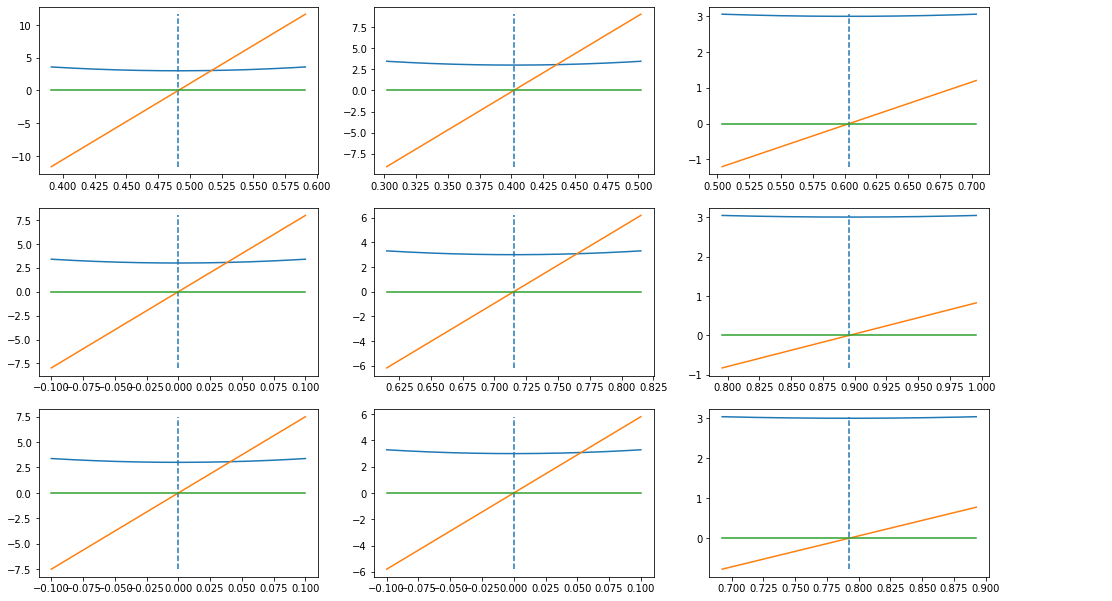

In [72]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients


# create figure
fig = plt.figure(1)

for i in range(n):
    for j in range(n):
        A2 = A.copy()
        
        ax = fig.add_subplot(n, n, i*n +j + 1)
        a_list = np.linspace(A[i][j] - 0.1, A[i][j] + 0.1, 500)

        results = [[], []]

        for a in a_list:
            A2[i][j] = a
            results[0].append(expected_cost(A2, P, As = As, Ps = Ps))
            results[1].append(grad_a(A2, P, i, j))

        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([a_list[0], a_list[-1]],[0, 0])
        plt.vlines(A[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [ ]:
def get_a_opt(A, P, i, j):
    # two points
    x1, x2 = A[i][j] - 0.01, A[i][j] + 0.01

    # save previous
    a_tmp = A[i][j]

    # get first points
    A[i][j] = x1
    y1 = grad_a(A, P, i, j)

    # get second point
    A[i][j] = x2
    y2 = grad_a(A, P, i, j)

    # restore A
    A[i][j] = a_tmp

    # calculate x_opt
    a = (y1 - y2) / (x1 - x2)
    b = y1 - a * x1
    x_opt = -b / a

    return x_opt

def get_A_opt(A, P):
    for i in range(n):
        for j in range(i + 1):
            A[i][j] = get_a_opt(A, P, i, j)
    return A

A = As.copy()
print(A)
A = get_A_opt(A, P)
print(A)

1.0
[0.462788762809474, 0.4641744831088701, 0.465560203407378, 0.4669459237067741, 0.46833164400528204, 0.46971736430467814, 0.47110308460363015, 0.47248880490258216, 0.47387452520153417, 0.47526024550093027, 0.4766459657994382, 0.4780316860992784, 0.4794174063973422, 0.4808031266967383, 0.4821888469961344, 0.4835745672946423, 0.48496028759359433, 0.48634600789299043, 0.48773172819194244, 0.48911744849089445]
[1.4035226030872705, 1.406706326317469, 1.4098900495476672, 1.413073772777865, 1.4162574960080634, 1.4194412192382613, 1.4226249424684598, 1.4258086656986575, 1.4289923889288563, 1.4321761121590542, 1.4353598353892523, 1.4385435586194506, 1.4417272818496487, 1.4449110050798464, 1.448094728310045, 1.4512784515402428, 1.454462174770441, 1.4576458980006395, 1.4608296212308376, 1.464013344461036]


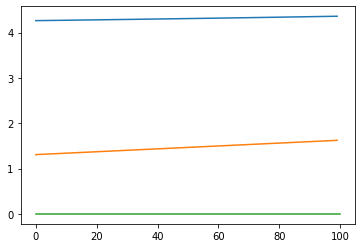

In [267]:
# verify gradients

P2 = P.copy()

i, j = 0, 1
print(P2[i][j])
p_list = np.linspace(P[i][j] - 0.1, P[i][j] + 0.1, 100)

results = [[], []]

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(A, P2, As = As, Ps = Ps))
    results[1].append(grad_p(A, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

der = [(j-i) * 100 / 0.2 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[30:50])
print(results[1][30:50])

In [ ]:
# verify gradients
p_list = np.linspace(0, 1, 100)
P2 = Ps.copy()

lambdas = 0.1 * np.ones((2, n))
lambdasineq = 0.5 * np.ones((n, n))

i, j = 0, 1

results = [[], []]

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(As, P2, As = As, Ps = Ps))
    results[1].append(grad_p(As, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

To deal with the constraints that $p$ must be non-negative, we project the entries by applying the sigmoid function of each entry. Note that the range of the sigmoid is $(0, 1)$, which is also what we require for our entries $p$ (we did not explicitly constrain $p$ to be smaller than 1, but the equality constraints combined with the non-negativity constraints make sure that is the case.
To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n p_{ij} - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n p_{ij} - 1\right),$$
where $P = \sigma(P_\sigma)$

start
2 0	

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

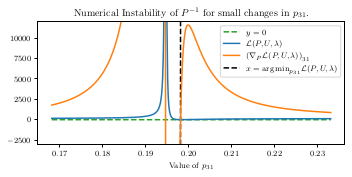

In [198]:
# # Create a Position index
# # plt.figure(figsize = (3 * n + 3, 3 * n))
# # plt.subplots_adjust(bottom = 0.0, left = -0.2)
# # position = range(1, n ** 2 + 1)

# # verify gradients

import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False

# create figure
fig = plt.figure()
fig = plt.figure(figsize = (5.5, 2.25))
print("start")

for i in range(n):
    for j in range(n):
        if i != 2 or j != 0: continue
        print(i, j, end = "\t")
        P2 = P.copy()
        
#         ax = fig.add_subplot(n, n, i*n +j + 1)
        p_list = np.linspace(P2[i][j] - 0.03, P2[i][j] + 0.035, 1000)

        results = [[], []]

        plt.ylim(-3e3, 12e3)
        for p in p_list:
            P2[i][j] = p
            results[0].append(min((expected_cost_lagrange(A, P2, As = As, Ps = Ps), 13e3)))
            results[1].append(max(min(grad_p(A, P2, i, j, As = As, Ps = Ps), 13e3), -13e3))
            
        plt.locator_params(axis='x', nbins=10)
        plt.xlabel(r"Value of $p_{31}$")
        plt.plot(p_list, np.zeros(1000), linestyle = '--', color = 'C2', label = r"$y=0$")
        plt.plot(p_list, results[0], label = r"$\mathcal{L}(P, U, \lambda)$")
        plt.plot(p_list, results[1], label = r"$\left(\nabla_P \mathcal{L}(P, U, \lambda)\right)_{31}$")
        
#         plt.plot([p_list[0], p_list[-1]],[0, 0])
        plt.vlines(P[i][j], np.min(results), np.max(results), linestyle = '--', color = 'black', label = r"$x = {\arg \min}_{p_{31}}\mathcal{L}(P, U, \lambda)$")

plt.title(r"Numerical Instability of $P^{-1}$ for small changes in $p_{31}$.")
plt.legend()
plt.savefig('gdlexinst13.pgf', bbox_inches = 'tight')
plt.show()

start
1 1	

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


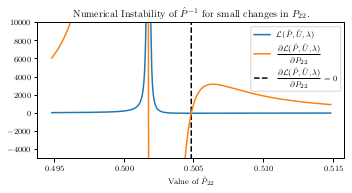

In [669]:
# Create a Position index
# plt.figure(figsize = (3 * n + 3, 3 * n))
# plt.subplots_adjust(bottom = 0.0, left = -0.2)
# position = range(1, n ** 2 + 1)

# verify gradients

import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False

# create figure
# fig = plt.figure()
fig = plt.figure(figsize = (5.5, 2.5))
print("start")

for i in range(n):
    for j in range(n):
        if i != 1 or j != 1: continue
        print(i, j, end = "\t")
        P2 = P.copy()
        
#         ax = fig.add_subplot(n, n, i*n +j + 1)
        p_list = np.linspace(P2[i][j] - 0.01, P2[i][j] + 0.01, 1000)

        results = [[], []]

        plt.ylim(-5e3, 10e3)
        for p in p_list:
            P2[i][j] = p
            results[0].append(min((expected_cost_lagrange(A, P2, As = As, Ps = Ps), 11e3)))
            results[1].append(max(min(grad_p(A, P2, i, j, As = As, Ps = Ps), 11e3), -11e3))
            
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(r"Value of $\hat{P}_{22}$")
        plt.plot(p_list, results[0], label = r"$\mathcal{L}(\hat{P}, \hat{U}, \lambda)$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial \mathcal{L}(\hat{P}, \hat{U}, \lambda)}{\partial P_{22}}$")
#         plt.plot([p_list[0], p_list[-1]],[0, 0])
        plt.vlines(P[i][j], np.min(results), np.max(results), linestyle = '--', color = 'black', label = r"$\frac{\partial \mathcal{L}(\hat{P}, \hat{U}, \lambda)}{\partial P_{22}} = 0$")

plt.title(r"Numerical Instability of $\hat{P}^{-1}$ for small changes in $P_{22}$.")
plt.legend()
plt.savefig('gdlexinst.pgf')
plt.show()

In [545]:
print(P)

[[0.02801232 0.48486653 0.48551027]
 [0.02791889 0.48802938 0.47905437]
 [0.93538434 0.03047884 0.03632637]]


start
0 0	0 1	0 2	0 3	0 4	0 5	1 0	1 1	1 2	1 3	1 4	1 5	2 0	2 1	2 2	2 3	2 4	2 5	3 0	3 1	3 2	3 3	3 4	3 5	4 0	4 1	4 2	4 3	4 4	4 5	5 0	5 1	5 2	5 3	

No handles with labels found to put in legend.


5 4	5 5	

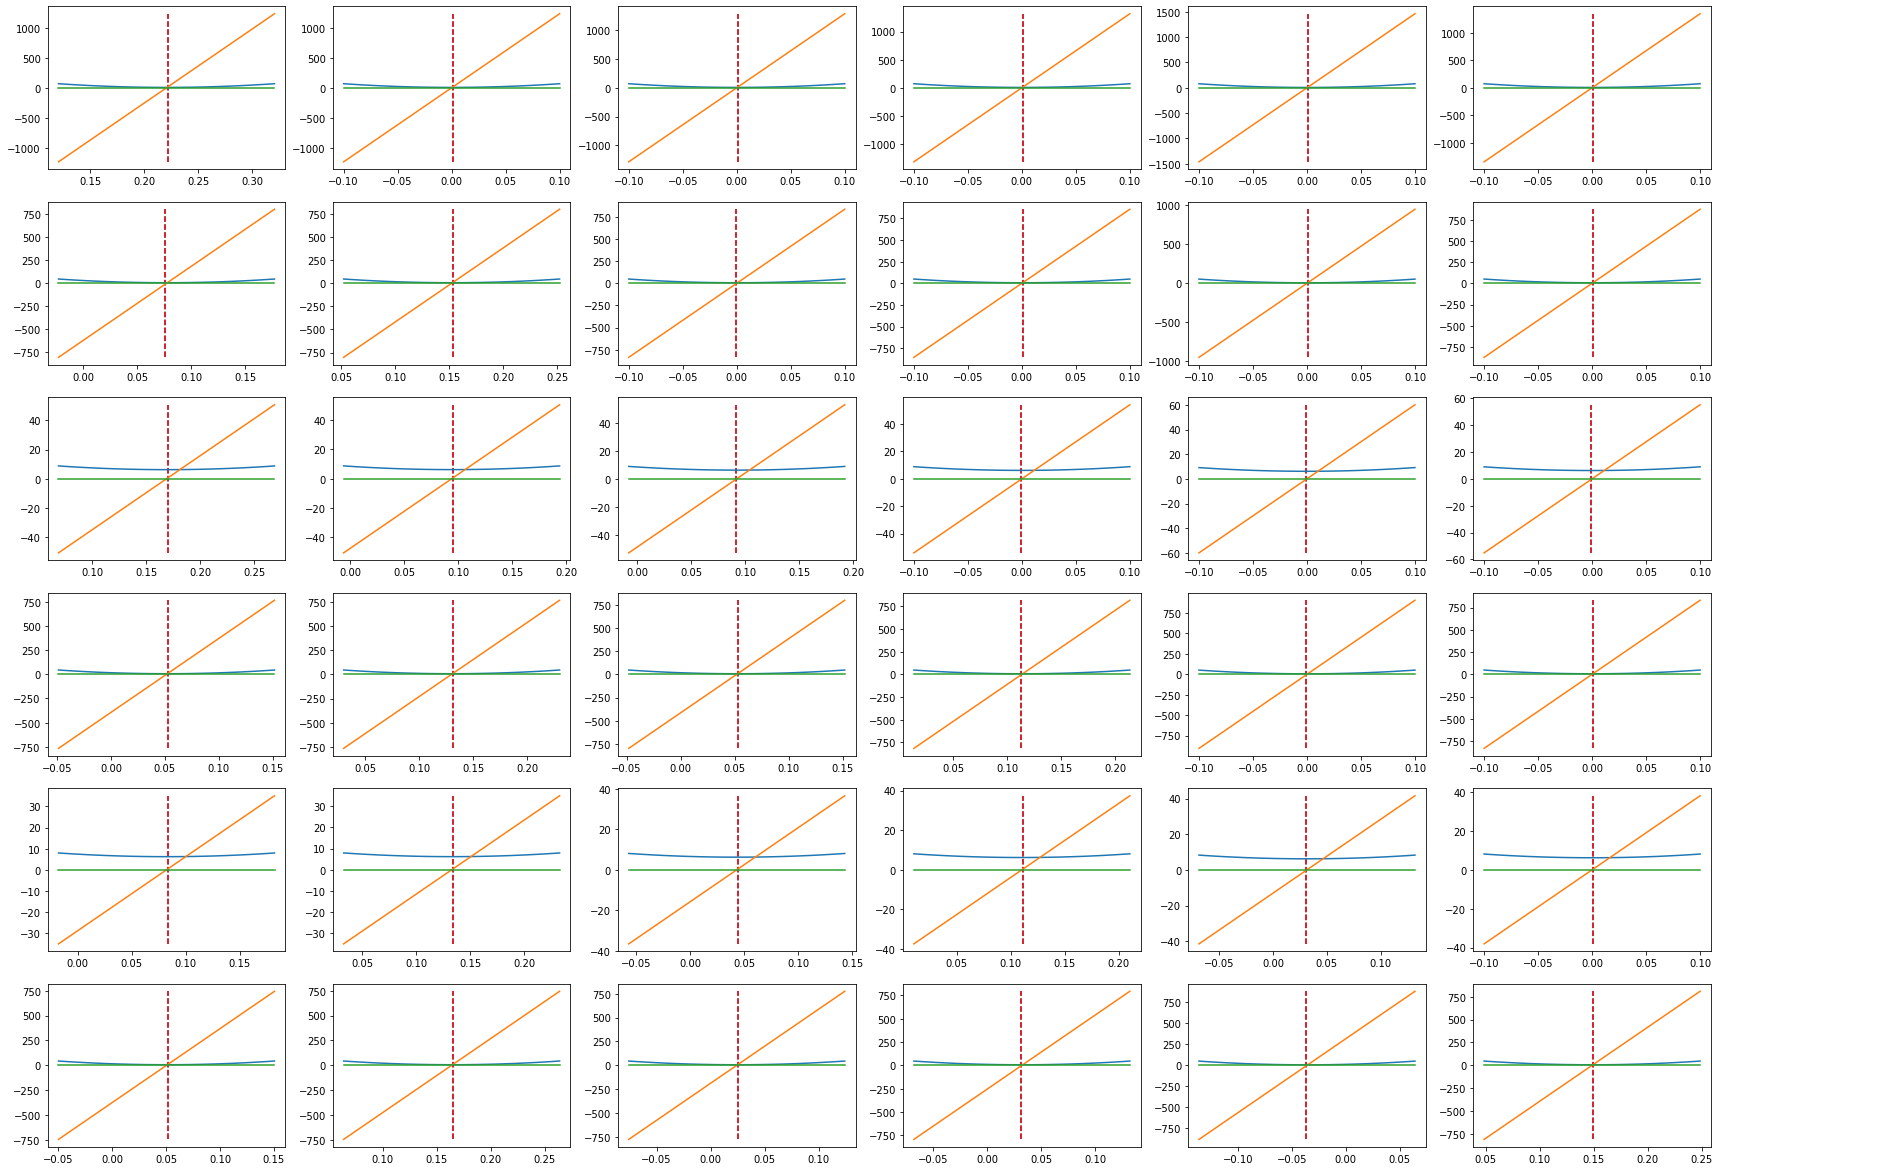

In [78]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients
# A = np.tril(np.random.rand(n, n))
# P = Ps.copy()
# create figure
fig = plt.figure(1)

print("start")

for i in range(n):
    for j in range(n):
        
        print(i, j, end = "\t")
        A2 = A.copy()
        
        ax = fig.add_subplot(n, n, i * n + j + 1)
        a_list = np.linspace(A2[i][j] - 0.1, A2[i][j] + 0.1, 100)

        results = [[], []]

        for a in a_list:
            A2[i][j] = a
            results[0].append(min((expected_cost_lagrange(A2, P = P, As = As, Ps = Ps), 1e4)))
            results[1].append(max(min(grad_a(A2, P, i, j, As = As, Ps = Ps), 1e4), -1e4))
            
        plt.locator_params(axis='x', nbins=6)
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([a_list[0], a_list[-1]],[0, 0])
        # minimizer of gradient
        plt.vlines(a_list[np.argmin(np.abs(results[1]))], np.min(results), np.max(results), linestyle = '--')
        # minimizer of cost, should correspond to minimizer of gradient
        plt.vlines(a_list[np.argmin(results[0])], np.min(results), np.max(results), linestyle = '--', color = 'r')
        # plt.vlines(As[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [249]:
print(As)

[[0.20462216 0.         0.        ]
 [0.14840792 0.26752171 0.        ]
 [0.13487388 0.23724791 0.07014774]]


0.0
[-3.8356042169532145, -3.757326579872533, -3.679048942791807, -3.60077130571117, -3.522493668630533, -3.444216031549807, -3.3659383944691257, -3.287660757388444, -3.209383120307807, -3.1311054832270813]
[-3.8359956051386064, -3.7585007444287353, -3.6810058837188646, -3.603511023008994, -3.5260161622991233, -3.448521301589252, -3.3710264408793815, -3.2935315801695104, -3.2160367194596393, -3.1385418587497687]


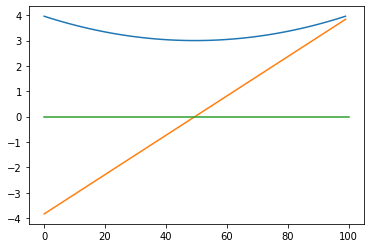

In [602]:
# verify gradients

A2 = As.copy()

i, j = 0, 1
print(A2[i][j])
w, N = 0.5, 100
a_list = np.linspace(A2[i][j] - w, A2[i][j] + w, N)

results = [[], []]

tmp = A2[i][j]
for a in a_list:
    A2[i][j] = a
    results[0].append(expected_cost(A2, Ps, As = As, Ps = Ps))
    results[1].append(grad_a(A2, Ps, i, j, As = As, Ps = Ps))
A2[i][j] = tmp

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, N],[0, 0])

der = [(j-i) / (2 * w / N) for i, j in zip(results[0][:-1], results[0][1:])]
print(der[:10])
print(results[1][:10])

In [327]:
grad_a(As, Ps, 0, 0, As = As, Ps = Ps)

-0.0